# RL4CRN tutorial notebook: RPA (CVODE)

Refer to the Logic Circuits tutorial for more information about the overall pipeline.


In [1]:
import os, sys, numpy as np

print("Python:", sys.version.split()[0])
print("CWD:", os.getcwd())


Python: 3.10.12
CWD: /local0/rossin/git/CRN-GenerativeAI/apps


## 1) Import RL4CRN helpers


In [ ]:
from RL4CRN.utils.input_interface import (
    Configurator,
    make_task,
    make_session_and_trainer,
    print_task_summary,
)
from RL4CRN.utils.default_tasks.TrackingTaskKind import TrackingTaskKind


## 2) Build a template IO/CRN

Here we use the convenience builder `build_simple_IOCRN`, which provides an easy way to construct a I/O CRNs specifying dictionaries for input and output nodes.


In [ ]:
from RL4CRN.utils.crn_builders import build_simple_IOCRN

# choose preset
cfg = Configurator.preset("paper")

# select simulator and set tolerances
cfg.solver.algorithm = "CVODE"
cfg.solver.rtol = 1e-10
cfg.solver.atol = 1e-10

# build template IO/CRN
species_labels = ['X_1', 'X_2', 'X_3']
crn, species_labels = build_simple_IOCRN(
    species=species_labels,
    production_input_map={"X_1": "u_1"},
    degradation_input_map={"X_3": "u_2"},
    dilution_map={},
    output_species="X_3",
    solver=cfg.solver,
)

print("Template CRN built.")
print(" - num_inputs:", crn.num_inputs)
print(" - num_species:", len(species_labels))
print(" - species:", species_labels)


Template CRN built.
 - num_inputs: 2
 - num_species: 3
 - species: ['X_1', 'X_2', 'X_3']


## 3) Build the reaction library (MAK)


In [4]:
from RL4CRN.utils.library_builders import build_MAK_library

# library components
library_components = build_MAK_library(crn, species_labels, order=2)

library, M, K, masks = library_components
print("Library built.")
print(" - M (num reactions in library):", M)
print(" - K (num parameters in library):", K)


Library built.
 - M (num reactions in library): 91
 - K (num parameters in library): 91


## 4) Define the task: RPA

- `kind="oscillator_mean"` selects the reward handler.
- `ic=("constant", 0.01)` sets initial concentrations.
- we use `u_values` to identify the combinations between input and disturbance
- we use `targets` to highlight the target output we seek to reach


In [ ]:
TrackingTaskKind.pretty_help()

### TaskKind `tracking`

**Required params**
- `target`: float OR callable with named args (recommended)
- `u_values`: List[float] values used for default grid inputs

**Optional params**
- `n_inputs`: int (defaults to template_crn.num_inputs)
- `t_f`: float
- `n_t`: int
- `ic`: IC spec
- `weights`: weights spec
- `u_list`: explicit u_list
- `u_spec`: ('custom'|'grid'|'linspace', ...) escape hatch
- `norm`: int (default 1)
- `LARGE_NUMBER`: float (default 1e4)

**Notes**
- Default u_list is cartesian product over u_values repeated n_inputs. If target is callable, its
  argument names are resolved via template_crn.input_idx_dict and template_crn.species_idx_dict.


In [ ]:
task = make_task(
    template_crn=crn,
    library_components=library_components,
    kind="tracking",
    species_labels=species_labels,
    params={
        "t_f": 100,
        "n_t": 1000,
        "ic": ("constant", 0.01),
        "weights": "transient",
        "u_values": [0.5, 1.0, 1.5], # the product (per input) of all the combinations of these values will be used 
        "target" : lambda u_1: u_1,  # target is a callable of the inputs (resolved via input_idx_dict)
    }
)

print_task_summary(task)

# --- Optional safety checks (recommended) ---
print("Sanity checks:")
print(" - template num_inputs:", crn.num_inputs)
print(" - first u shape:", np.asarray(task.u_list[0]).shape)
print(" - first u length:", len(task.u_list[0]))
assert len(task.u_list[0]) == crn.num_inputs, "Input dimension mismatch: u has wrong length!"


Task: tracking
time_horizon: (1000,) [0..100.0]
num scenarios: 9
first 3 u: [array([0.5, 0.5], dtype=float32), array([0.5, 1. ], dtype=float32), array([0.5, 1.5], dtype=float32)]

Sanity checks:
 - template num_inputs: 2
 - first u shape: (2,)
 - first u length: 2


## 5) Training configuration

We tune:
- `max_added_reactions`: episode length (how many reactions the agent can add)
- `epochs`: training iterations
- `render_every`: print progress cadence
- `seed`: reproducibility


In [7]:
# ---- Train config ----
cfg.train.max_added_reactions = 5
cfg.train.epochs = 5
cfg.train.render_every = 5
cfg.train.seed = 0

In [ ]:
cfg.render.n_best = 50
cfg.render.disregarded_percentage = 0.9
cfg.render.mode = {  # Mode of the experiment
    'style': 'logger', 
    'task': 'transients', 
    'format': 'image',
    'topology': True
}

## 6) Inspect full configuration (optional)

`cfg.describe()` prints a nested configuration dictionary.


In [8]:
cfg.describe()

{'task': None,
 'solver': {'algorithm': 'CVODE', 'rtol': 1e-10, 'atol': 1e-10},
 'train': {'epochs': 5,
           'max_added_reactions': 5,
           'render_every': 5,
           'hall_of_fame_size': 50,
           'batch_multiplier': 10,
           'seed': 0,
           'n_cpus': None,
           'batch_size': None},
 'policy': {'width': 1024,
            'depth': 5,
            'deep_layer_size': 10240,
            'continuous_distribution': {'type': 'lognormal_1D'},
            'entropy_weights_per_head': {'structure': 2.0, 'continuous': 1.0, 'discrete': 0.0, 'input_influence': 0.0},
            'ordering_enabled': False,
            'constraint_strength': inf},
 'agent': {'learning_rate': 0.0001,
           'entropy_scheduler': {'entropy_weight': 0.001,
                                 'topk_entropy_weight': 1.0,
                                 'remainder_entropy_weight': 1.0,
                                 'entropy_update_coefficient': 1,
                                 'en

## 7) Create session + trainer

This step wires together:
- parallel environments
- observer/tensorizer/actuator/stepper interfaces
- policy + agent
- the chosen task reward function

The returned object:
- `trainer`: runs rollout → reward eval → policy update loops


In [ ]:
import os
from datetime import datetime
from pytorch_lightning.loggers import CometLogger

task_name = "RPA_Task"
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Expect these in your environment:
#   COMET_API_KEY   (required)
#   COMET_WORKSPACE (required)
api_key = os.environ["COMET_API_KEY"]
workspace = os.environ["COMET_WORKSPACE"]

logger = CometLogger(
    api_key=api_key,
    project=task_name,
    workspace=workspace,
    name=f"{task_name}_{timestamp}",
)

logger = logger.experiment


In [ ]:
trainer = make_session_and_trainer(cfg, task, logger=logger)

## 8) Train and save checkpoints

We run for `cfg.train.epochs` epochs and periodically save a checkpoint.


In [10]:
checkpoint_path = "RPA_task_chkpt.pkl"
trainer.run(epochs=cfg.train.epochs, checkpoint_path=checkpoint_path)



[cvHandleFailure, Error: -15] At t = 9.95121777593565, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 22.0129669887204, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 25.8564328272157, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 6.61458854639098, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 11.8775122165328, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 4.55463320434705, unable to satisfy inequality constraints.

[epoch 0] best loss=0.2816 | median loss=2.438
Saved checkpoint: RPA_task_chkpt.pkl

[cvHandleFailure, Error: -15] At t = 12.4718192006114, unable to satisfy inequality constraints.


[CVode, Error: -1] At t = 8.58995051986244, mxstep steps taken before reaching tout.


[CVode, Error: -1] At t = 7.99068821939201, mxstep steps taken before reaching tout.


[CVode, Error: -1] At t = 8.8973825801895, mxste

## 9) Inspect the best CRN

The trainer keeps a **Hall of Fame** of good CRNs found during rollouts.


Best CRN loss: 0.23515066247082092
Inputs: ['u_1', 'u_2'] 
Species: ['X_1', 'X_2', 'X_3'] 
Output Species: ['X_3'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
∅ ----> X_3;  [MAK(1.0, u_2)]
X_1 ----> X_2 + X_3;  [MAK(0.14894536137580872)]
X_1 ----> X_3 + X_3;  [MAK(0.8714479207992554)]
X_3 ----> X_2 + X_2;  [MAK(0.9133807420730591)]
X_1 + X_2 ----> X_1;  [MAK(0.4946763515472412)]
X_3 + X_3 ----> X_2 + X_2;  [MAK(0.7640494704246521)]
Hall of Fame size: 50
Best loss: 0.23515066247082092


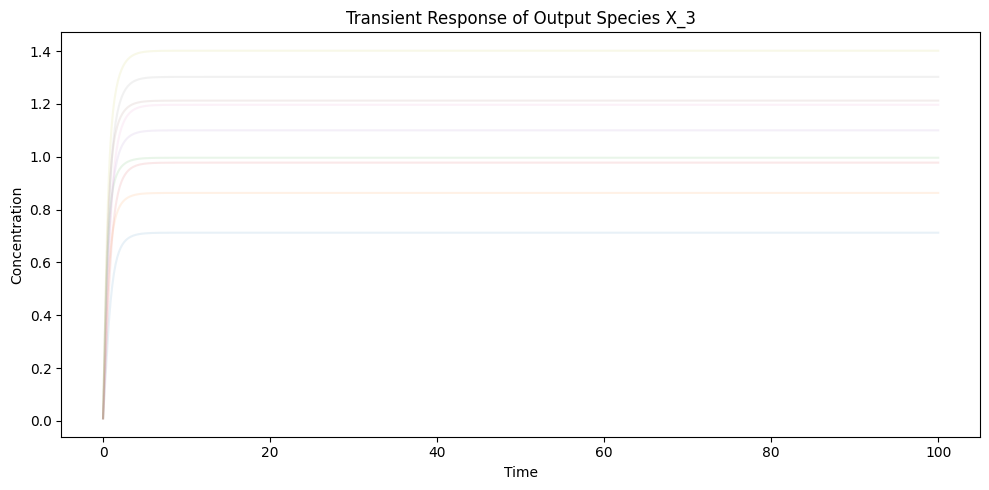

In [11]:
trainer.inspect_best(plot=True)

best = trainer.best_crn()
print("Hall of Fame size:", len(trainer.s.mult_env.hall_of_fame))
if best is not None:
    print("Best loss:", best.last_task_info.get("reward", None))


## 10) Sample and re-simulate

After training, we can **draw new CRN designs from the learned policy** (sampling runs in evaluation mode, i.e., no gradient updates) and **re-evaluate** them.

This is useful for:
- **Model exploration:** quickly inspect diverse candidates generated by the policy.
- **Controlled re-simulation:** re-run sampled CRNs under modified conditions (`u_list/u_spec`, `ic`, etc.).

Sampling produces a dedicated **sample Hall-of-Fame** that stores the best `K` sampled environments (lowest loss) for later inspection and checkpointing.


In [12]:
trainer.sample(10, 10, ic=("constant", 1.0))

We can now inspect newly sampled I/O CRNs.

Inputs: ['u_1', 'u_2'] 
Species: ['X_1', 'X_2', 'X_3'] 
Output Species: ['X_3'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
∅ ----> X_3;  [MAK(1.0, u_2)]
X_3 ----> X_1;  [MAK(0.29591119289398193)]
X_1 + X_2 ----> X_2;  [MAK(0.22304555773735046)]
X_1 + X_2 ----> X_3;  [MAK(0.46598026156425476)]
X_1 + X_3 ----> X_1 + X_2;  [MAK(1.299889087677002)]
X_3 + X_3 ----> X_3;  [MAK(1.1936014890670776)]
reward: 0.42833901550793657


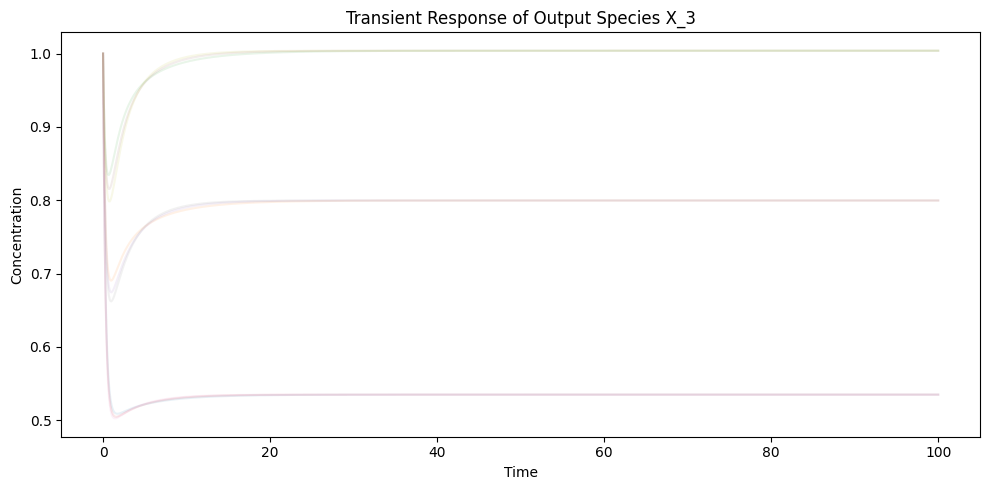

In [13]:
import matplotlib.pyplot as plt

index = 0
crn_s = trainer.get_sampled_crns()[index]
print(crn_s)
print("reward:", crn_s.last_task_info.get("reward", None))

# Plotters depend on your IOCRN implementation
crn_s.plot_transient_response(); plt.show()


Save again our results.

In [14]:
trainer.save(checkpoint_path)

Saved checkpoint: RPA_task_chkpt.pkl


## 11) Loading a saved Session/Trainer from a checkpoint

`load_session_and_trainer` reconstructs wiring and restores weights, history, HoFs, and RNG states.


Best CRN loss: 0.23515066247082092
Inputs: ['u_1', 'u_2'] 
Species: ['X_1', 'X_2', 'X_3'] 
Output Species: ['X_3'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
∅ ----> X_3;  [MAK(1.0, u_2)]
X_1 ----> X_2 + X_3;  [MAK(0.14894536137580872)]
X_1 ----> X_3 + X_3;  [MAK(0.8714479207992554)]
X_3 ----> X_2 + X_2;  [MAK(0.9133807420730591)]
X_1 + X_2 ----> X_1;  [MAK(0.4946763515472412)]
X_3 + X_3 ----> X_2 + X_2;  [MAK(0.7640494704246521)]


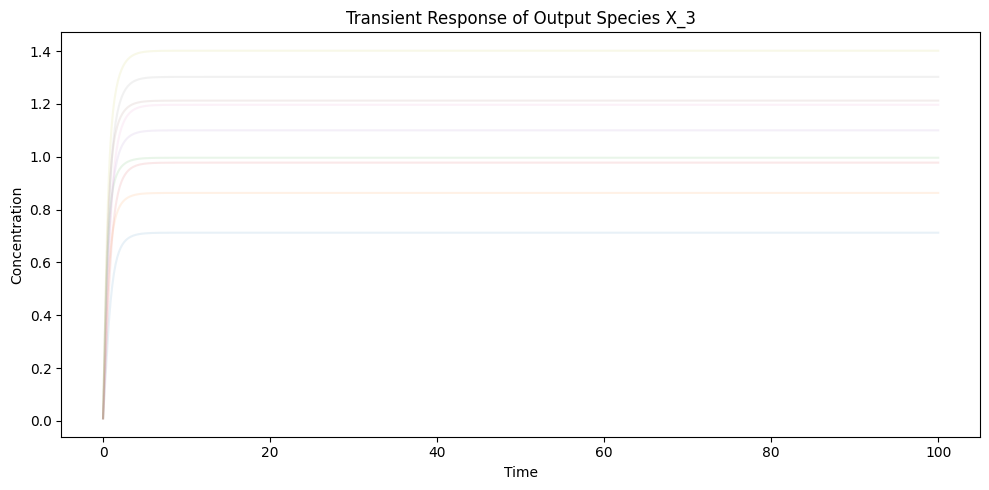

In [15]:
from RL4CRN.utils.input_interface import load_session_and_trainer

trainer_loaded = load_session_and_trainer(checkpoint_path, device="cuda")
trainer_loaded.inspect_best()

## 12) Re-simulate Hall-of-Fame CRNs under new conditions

We can take the training Hall-of-Fame CRNs and re-simulate them under a new IC and/or new input set.

This uses `Trainer.resimulate(...)` which clones CRNs before evaluation (so old results remain intact).


CRN loss: 0.2165846766748689
Inputs: ['u_1', 'u_2'] 
Species: ['X_1', 'X_2', 'X_3'] 
Output Species: ['X_3'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
∅ ----> X_3;  [MAK(1.0, u_2)]
X_1 ----> X_2 + X_3;  [MAK(0.14894536137580872)]
X_1 ----> X_3 + X_3;  [MAK(0.8714479207992554)]
X_3 ----> X_2 + X_2;  [MAK(0.9133807420730591)]
X_1 + X_2 ----> X_1;  [MAK(0.4946763515472412)]
X_3 + X_3 ----> X_2 + X_2;  [MAK(0.7640494704246521)]


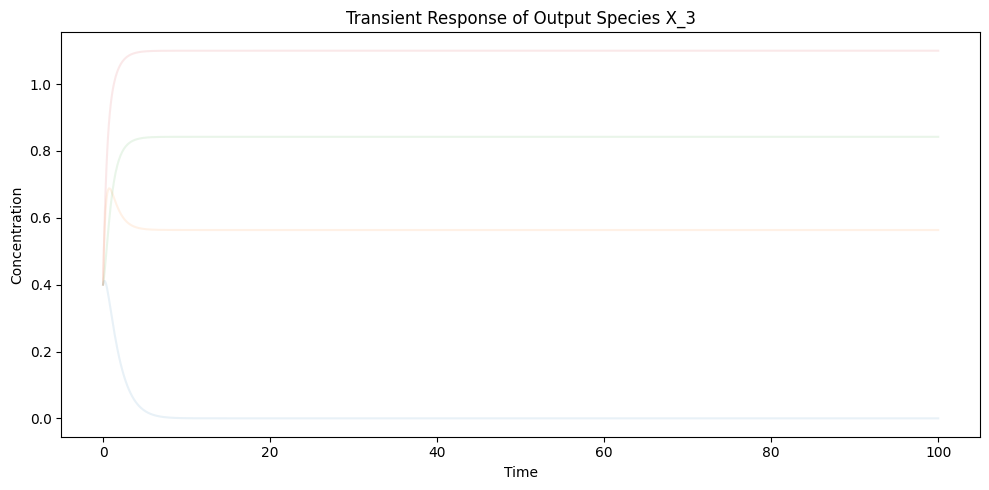

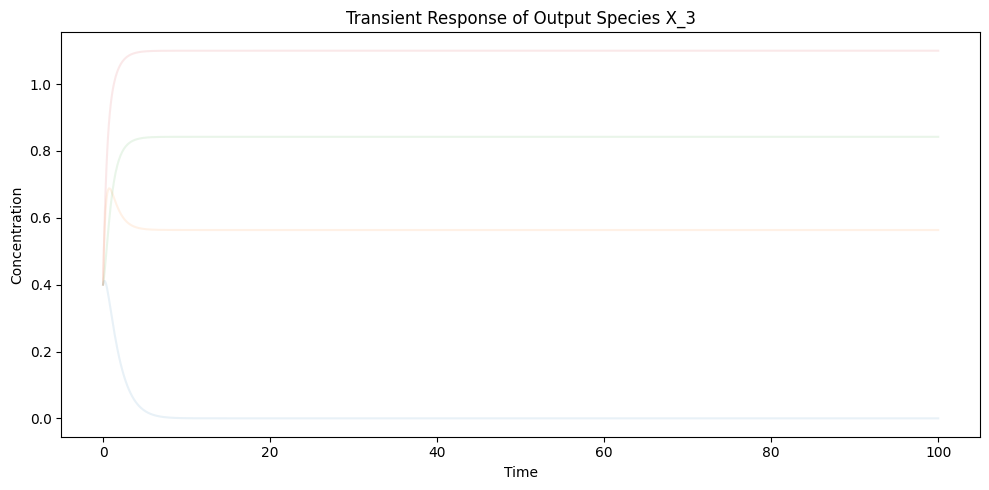

In [16]:
hof_crns = [item.state for item in trainer.s.mult_env.hall_of_fame]

trainer.s.crn_template

crns_new = trainer.resimulate(
    hof_crns,
    ic=("constant", 0.4), 
    u_spec=("grid", [0.0, 1.0]),
)

trainer.inspect(crns_new[0])
crns_new[0].plot_transient_response(); plt.show()
